# Loan Default Risk Prediction

**Goal:** Predict whether a person is at risk of defaulting on their payment.

**Dataset link:** github.com/MatteoM95/Default-of-Credit-Card-Clients-Dataset-Analisys

**Dataset columns:** `ID`, `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`, `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6`, `BILL_AMT1`, `BILL_AMT2`, `BILL_AMT3`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6`, `PAY_AMT1`, `PAY_AMT2`, `PAY_AMT3`, `PAY_AMT4`, `PAY_AMT5`, `PAY_AMT6`, `default payment next month`

**Target definition:** `Default = 1` if the client defaults on the payment the following month, else `0`.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt


In [2]:
DATA_PATH = "/content/drive/MyDrive/Notes & Practice/Datasets/default_of_credit_card_clients.csv"
Path(DATA_PATH)
df = pd.read_csv(DATA_PATH)

In [3]:
print('Columns:', list(df.columns))
print('\nMissing values per column:\n', df.isna().sum())
print('\nBasic stats:\n', df.describe(include='all').T.head(20))

Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']

Missing values per column:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                     

In [4]:
for i in range(1, 7):
    df[f'PAY_RATIO{i}'] = df[f'PAY_AMT{i}'] / (df[f'BILL_AMT{i}'] + 1e-5)

for i in range(1, 7):
    df[f'BALANCE_DIFF{i}'] = df[f'BILL_AMT{i}'] - df[f'PAY_AMT{i}']


In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. Utilization ratio (latest bill vs. credit limit)
df['utilization_ratio'] = df['BILL_AMT1'] / df['LIMIT_BAL']
df['utilization_ratio'] = df['utilization_ratio'].clip(0, 1)  # cap at 100%

# 2. Repayment trend (linear slope over PAY_AMT1-6)
def calc_repay_trend(row):
    y = row[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].values
    x = np.arange(1, 7).reshape(-1, 1)  # months 1..6
    if np.all(y == 0):  # if no payments at all
        return 0
    model = LinearRegression().fit(x, y)
    return model.coef_[0]

df['repay_trend'] = df.apply(calc_repay_trend, axis=1)


In [6]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (30000, 39)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month', 'PAY_RATIO1', 'PAY_RATIO2', 'PAY_RATIO3', 'PAY_RATIO4', 'PAY_RATIO5', 'PAY_RATIO6', 'BALANCE_DIFF1', 'BALANCE_DIFF2', 'BALANCE_DIFF3', 'BALANCE_DIFF4', 'BALANCE_DIFF5', 'BALANCE_DIFF6', 'utilization_ratio', 'repay_trend']


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_RATIO5,PAY_RATIO6,BALANCE_DIFF1,BALANCE_DIFF2,BALANCE_DIFF3,BALANCE_DIFF4,BALANCE_DIFF5,BALANCE_DIFF6,utilization_ratio,repay_trend
0,1,20000,2,2,1,24,2,2,-1,-1,...,0.000000,0.000000,3913,2413,689,0,0,0,0.195650,-59.057143
1,2,120000,2,2,2,26,-1,2,0,0,...,0.000000,0.613309,2682,725,1682,2272,3455,1261,0.022350,200.000000
2,3,90000,2,2,2,34,0,0,0,0,...,0.066899,0.321564,27721,12527,12559,13331,13948,10549,0.324878,454.571429
3,4,50000,2,2,1,37,0,0,0,0,...,0.036914,0.033844,44990,46214,48091,27214,27890,28547,0.939800,-227.142857
4,5,50000,1,2,1,57,-1,0,-1,0,...,0.035987,0.035492,6617,-31011,25835,11940,18457,18452,0.172340,-3302.314286


In [7]:
# Target column
y = df['default payment next month']

# Drop ID
X = df.drop(columns=['ID', 'default payment next month'])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)



Train shape: (24000, 37) Val shape: (6000, 37)


In [8]:
# Drop raw BILL_AMT and PAY_AMT columns
cols_to_drop = [col for col in X.columns if col.startswith("BILL_AMT") or col.startswith("PAY_AMT")]
X_reduced = X.drop(columns=cols_to_drop)

print("Original feature count:", X.shape[1])
print("Reduced feature count:", X_reduced.shape[1])

Original feature count: 37
Reduced feature count: 25


In [9]:
numeric_features = ['LIMIT_BAL', 'AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE'] + [f'PAY_{i}' for i in [0,2,3,4,5,6]]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [10]:
# Build pipeline with preprocessing + logistic regression
log_reg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_val)
y_proba = log_reg.predict_proba(X_val)[:,1]

# Evaluate
print("=== Logistic Regression ===")
print(classification_report(y_val, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, y_proba))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.49      0.55      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.78      0.77      0.78      6000

ROC AUC: 0.7587834424085775


In [11]:

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow fully
    random_state=42,
    class_weight='balanced',
    n_jobs=-1               # use all cores for speed
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:, 1]

# Evaluate
print("=== Random Forest ===")
print(classification_report(y_val, y_pred_rf, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, y_prob_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.64      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000

ROC AUC: 0.758930594408611


In [12]:
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

xgb_weighted = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,  # weight balancing
    eval_metric="logloss"
)

xgb_weighted.fit(X_train, y_train)

y_pred_xgb_w = xgb_weighted.predict(X_val)
y_prob_xgb_w = xgb_weighted.predict_proba(X_val)[:, 1]

# Evaluate
print("=== XGBoost (with class weights) ===")
print(classification_report(y_val, y_pred_xgb_w, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, y_prob_xgb_w))


=== XGBoost (with class weights) ===
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4673
           1       0.47      0.60      0.53      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.79      0.76      0.77      6000

ROC AUC: 0.76726052644777


In [13]:
import shap
shap.initjs()

In [14]:
explainer = shap.Explainer(xgb_weighted)
shap_values = explainer(X_val)

In [15]:
np.shape(shap_values.values)

(6000, 37)

## Waterfall Plot

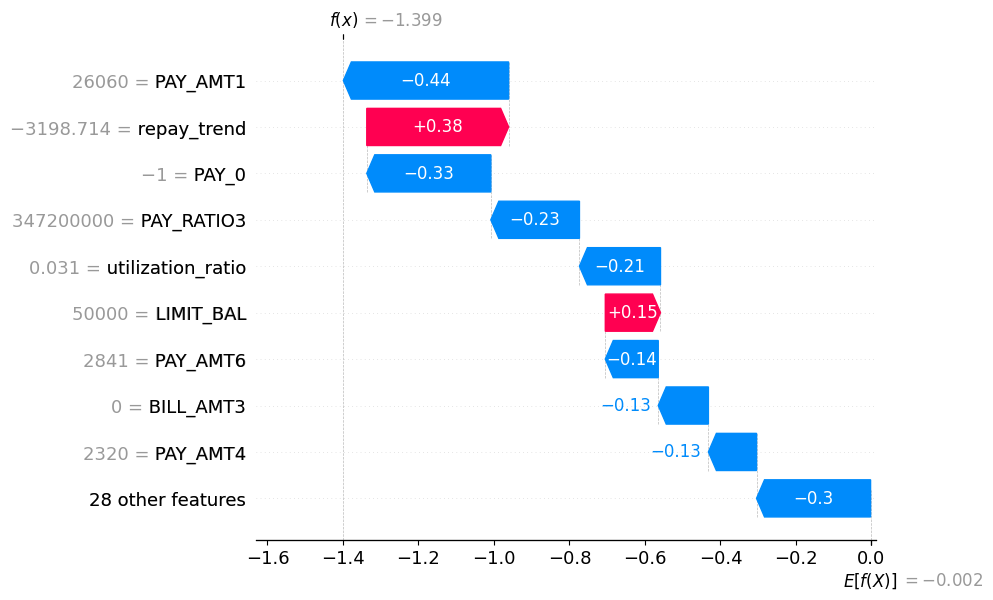

In [16]:
shap.plots.waterfall(shap_values[0])

f(x) = prediction for that observation

E[f(x)] = average prediction

## Bar Plot

These features have made the most significant contributions to the model predictions

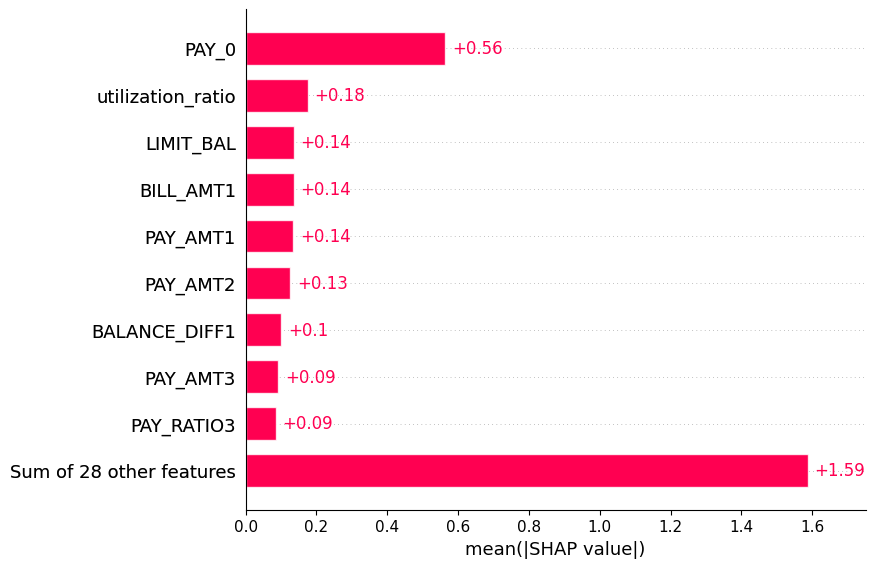

In [17]:
shap.plots.bar(shap_values, max_display=10)

## Beeswarm Plot

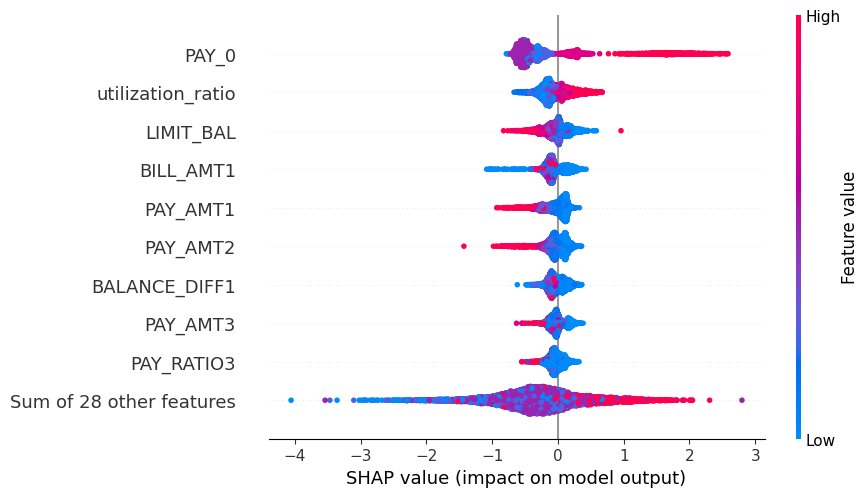

In [18]:
shap.plots.beeswarm(shap_values, max_display=10)

## Dependence Plots

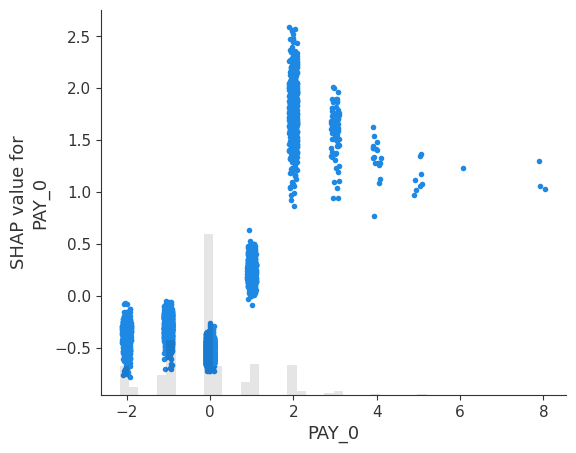

In [19]:
shap.plots.scatter(shap_values[:, 'PAY_0'])

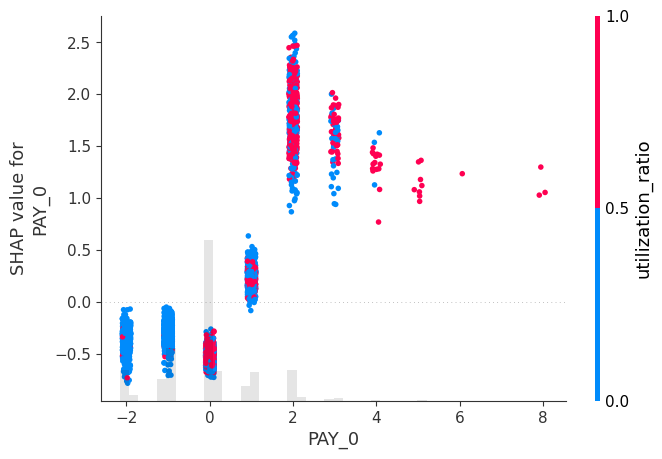

In [20]:
shap.plots.scatter(shap_values[:, 'PAY_0'], color=shap_values[:, 'utilization_ratio'])

## Example of explanation provided to user

In [23]:
i = 0
shap_values_for_row = shap_values[i].values
feature_names = X_val.columns

top_features = sorted(
    zip(feature_names, shap_values_for_row),
    key=lambda x: abs(x[1]),
    reverse=True
)[:3]

for f, val in top_features:
    direction = "increased" if val > 0 else "decreased"
    print(f"{f} {direction} the default risk.")


PAY_AMT1 decreased the default risk.
repay_trend increased the default risk.
PAY_0 decreased the default risk.
